<a href="https://colab.research.google.com/github/Hosein-Ghojavand/Farsi-English-SMS-Spam-Detection/blob/main/English_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install datasets

In [3]:
import pandas as pd
import numpy as np
from datasets import  Dataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv("/content/drive/MyDrive/NLP Files/spam.csv", encoding='latin1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [5]:
# drop last 3 columns; which are not usefull
df = df[["v1","v2"]]

In [6]:
# rename columns names
df.rename(columns={"v1":"Class", "v2":"text"}, inplace=True)

<ipython-input-6-5a8191af97a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"v1":"Class", "v2":"text"}, inplace=True)


In [7]:
# Check for duplicates and remove them if found
if df.duplicated().sum() > 0:
    print("Found duplicate rows. Removing them...")
    df = df.drop_duplicates()

Found duplicate rows. Removing them...


In [8]:
# Convert labels to binary
df['label'] = df['Class'].map({'ham': 0, 'spam': 1})

In [9]:
# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [10]:
# Convert back to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

We load the BERT tokenizer using BertTokenizer.from_pretrained('bert-base-uncased').
Our tokenize_function takes care of tokenizing the text, padding or truncating to a maximum length of 128 tokens, and adding the labels.

In [11]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    # Tokenize the texts
    tokenized = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    # Add labels to the tokenized output
    tokenized["labels"] = examples["label"]
    return tokenized

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
# Apply tokenization to our datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/4135 [00:00<?, ? examples/s]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

In [13]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [15]:
# !pip install transformers[torch]

In [16]:
from transformers import DataCollatorWithPadding

In [18]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    per_device_train_batch_size=16,  # Increase batch size if memory allows
    per_device_eval_batch_size=16,
    num_train_epochs=2,  # Reduce number of epochs for quicker training
    weight_decay=0.01,
    fp16=True,  # Enable mixed precision training
)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# ! pip install -U accelerate
# ! pip install -U transformers

In [22]:
import accelerate
import transformers
transformers.__version__, accelerate.__version__

('4.42.4', '0.32.1')

In [23]:

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.034875,0.993230,0.975265,1.000000,0.951724
2,0.048900,0.034507,0.992263,0.972414,0.972414,0.972414


TrainOutput(global_step=518, training_loss=0.04770635022389843, metrics={'train_runtime': 90.4718, 'train_samples_per_second': 91.41, 'train_steps_per_second': 5.726, 'total_flos': 543982106956800.0, 'train_loss': 0.04770635022389843, 'epoch': 2.0})

{'eval_loss': 0.034507278352975845, 'eval_accuracy': 0.9922630560928434, 'eval_f1': 0.9724137931034482, 'eval_precision': 0.9724137931034482, 'eval_recall': 0.9724137931034482, 'eval_runtime': 2.1166, 'eval_samples_per_second': 488.519, 'eval_steps_per_second': 30.71, 'epoch': 2.0}


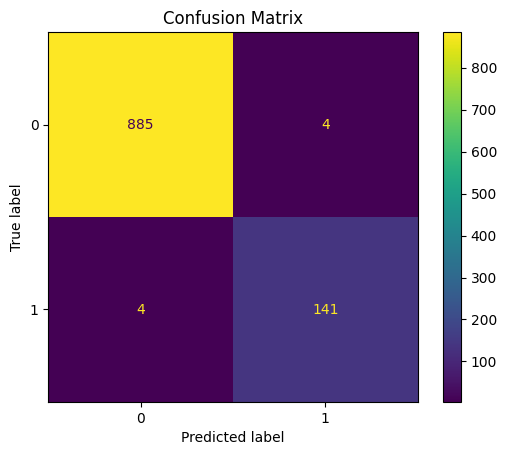

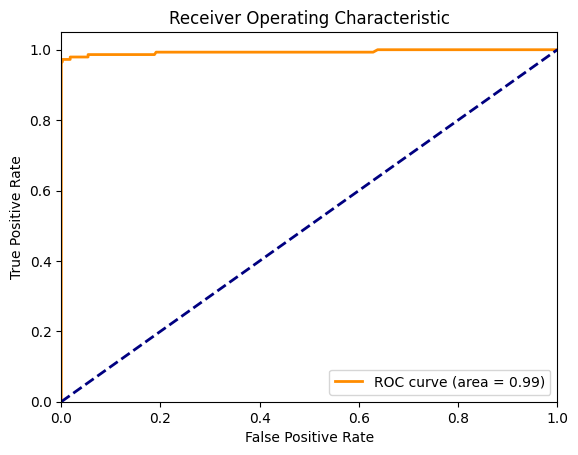

Sensitivity: 0.9724137931034482
Specificity: 0.9955005624296963


In [24]:
# Evaluate the model
evaluation = trainer.evaluate()
print(evaluation)

# Get predictions on the test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc
import numpy as np

y_pred_proba = predictions.predictions[:, 1]
fpr, tpr, _ = roc_curve(labels, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Sensitivity and Specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')